# Deep learning (Part 2)

Link to Datasets: [AMZN_train](https://drive.google.com/file/d/1cVpK7WrUA2-tWQe73BPFE5C4CZ3gT3iO/view?usp=sharing), [AMZN_test](https://drive.google.com/file/d/1oK4pXOQeU-8SIRAvuB7j-1TdiF9DvvTr/view?usp=sharing)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Input

keras.utils.set_random_seed(123)

## Recurrent Neural Networks

##### Data Preprocessing
inputs of Keras can only be numpy arrays

In [5]:
dataset_train = pd.read_csv('/content/AMZN_train.csv')
# use column 'close' and convert it to np array
training_set = dataset_train.iloc[:, 4:5].values
len(training_set)

525

In [7]:
training_set.shape

(525, 1)

Feature Scaling

In [8]:
# normalize your data for RNN
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

Creating a data structure with 30 timesteps and 1 output

In [9]:
# lag = 30, n_obs = 525
X_train = []
y_train = []
for i in range(30, 525):
  X_train.append(training_set_scaled[i-30:i, 0]) # upperbound not included
  y_train.append(training_set_scaled[i, 0])
X_train , y_train = np.array(X_train), np.array(y_train) # convert list to np array
X_train.shape

(495, 30)

Reshaping: anytime you want to add dimensions to np array, you can use reshape

In [10]:
# specify or add indicators(here 1, close price)
# keras documentation-> Recurrent Layers -> Input shape: (batch_size,timesteps,input_dim)
batch_size = X_train.shape[0]
timesteps = X_train.shape[1]

X_train = np.reshape(X_train, (batch_size, timesteps, 1))



## Building and Training an LSTM

LSTM architecture (you can create a similar architecture with GRU units instead of LSTM).

Recurrent layers [documentations](https://keras.io/api/layers/recurrent_layers/)

In [11]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# return_sequences = True, because we want to add another LSTM layer after this
model.add(Dropout(rate=0.2)) # 20% of the neurans will be droped out during each training iteration

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding the last LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

Fitting the LSTM to the Training set

In [13]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
16/16 [==============================] - 8s 11ms/step - loss: 0.1312
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0237
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0168
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 6/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0105
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 8/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 9/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 10/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 11/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 12/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 13/50
16/16 [=============================

##### Making the predictions and visualising the results

Getting the predicted stock price of Feb 2022:
we need to concatenate test set with training set (before normalization) to use 30 observation before Feb 2022.

In [17]:
# transform and create sequences for Test data
dataset_test = pd.read_csv('/content/AMZN_test.csv')
real_stock_price = dataset_test.iloc[:,4:5].values

data_set_total = pd.concat([dataset_train['Close'], dataset_test['Close']], axis = 0)
inputs = data_set_total[len(data_set_total)- len(dataset_test) - 30:].values
# reshape inputs to get a numpy array with rows and one column
inputs = inputs.reshape(-1,1)
# scale inputs (like what we did with training set)
inputs = sc.transform(inputs)
X_test = []
# test set contains 14 observations
for i in range (30,inputs.shape[0]):
  X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))


In [23]:
pred_stock_price = model.predict(X_test)
# rescale to original format
pred_stock_price = sc.inverse_transform(pred_stock_price)
RMSE = np.sqrt(np.mean((pred_stock_price-real_stock_price)**2))
RMSE

1/1 [==============================] - 0s 20ms/step


143.9703425769727

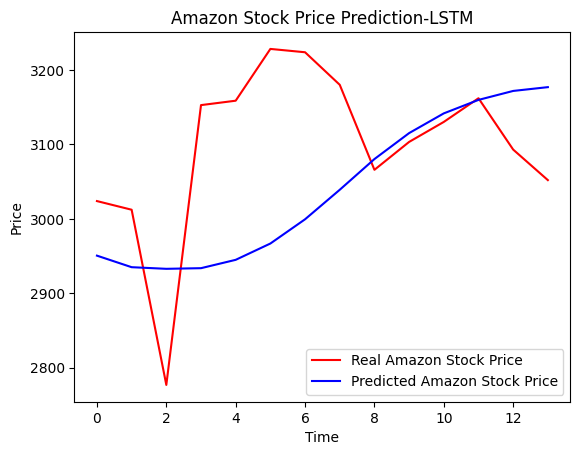

In [24]:
plt.plot(real_stock_price, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(pred_stock_price, color = 'blue', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## BiGRU

In [25]:
from keras.layers import Bidirectional

model_bigru = Sequential([
    Input(shape=((timesteps, 1))),
    Bidirectional(GRU(10, return_sequences=True)),
    Bidirectional(GRU(10)),
    Dense(1, activation="relu"),
])
model_bigru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 20)            780       
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                1920      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2721 (10.63 KB)
Trainable params: 2721 (10.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model_bigru.compile(loss='mean_squared_error', optimizer='rmsprop')
# Fitting
model_bigru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
16/16 [==============================] - 6s 10ms/step - loss: 0.1466
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 9/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 11/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 12/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 13/50
16/16 [=============================

In [27]:
pred_stock_price = model_bigru.predict(X_test)
# rescale to original format
pred_stock_price = sc.inverse_transform(pred_stock_price)
RMSE = np.sqrt(np.mean((pred_stock_price-real_stock_price)**2))
RMSE

1/1 [==============================] - 1s 1s/step


117.74103250812821

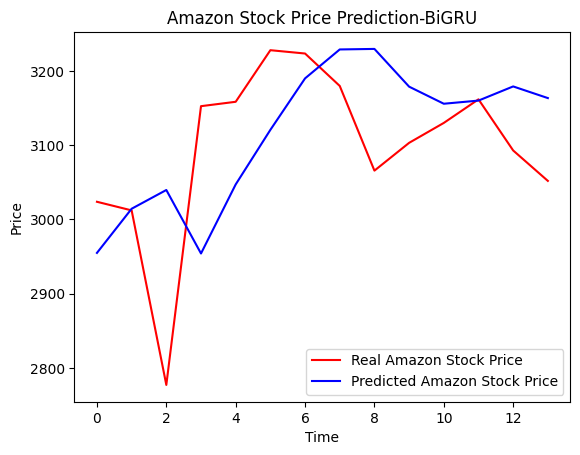

In [28]:
plt.plot(real_stock_price, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(pred_stock_price, color = 'blue', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction-BiGRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Temporal Convolutional Networks (TCN)

TCN [Github](https://github.com/philipperemy/keras-tcn)

In [29]:
!pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

In [30]:
model_tcn = Sequential([Input(shape=(timesteps, 1)),
        TCN(nb_filters=64, kernel_size=3, return_sequences=True, dilations=[1, 2, 4, 8, 16]),
        Dense(1) # Output layer
    ])
model_tcn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 30, 64)            111552    
                                                                 
 dense_2 (Dense)             (None, 30, 1)             65        
                                                                 
Total params: 111617 (436.00 KB)
Trainable params: 111617 (436.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model_tcn.compile(loss='mean_squared_error', optimizer='rmsprop')
# Fitting
model_tcn.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
16/16 [==============================] - 5s 32ms/step - loss: 15.7229
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.7335
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.8223
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.7511
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.4302
Epoch 6/50
16/16 [==============================] - 0s 8ms/step - loss: 0.4150
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.2010
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1480
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1837
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1199
Epoch 11/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1373
Epoch 12/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1006
Epoch 13/50
16/16 [======================

In [32]:
pred_stock_price = model_tcn.predict(X_test)[:,-1,:] # get the last sequence
# rescale to original format
pred_stock_price = sc.inverse_transform(pred_stock_price)
RMSE = np.sqrt(np.mean((pred_stock_price-real_stock_price)**2))
RMSE

1/1 [==============================] - 1s 560ms/step


140.71397156076588

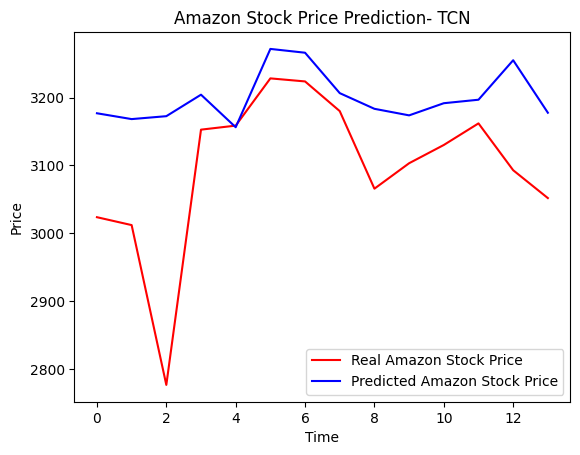

In [33]:
plt.plot(real_stock_price, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(pred_stock_price, color = 'blue', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price Prediction- TCN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()